# Collecting and Condensing COVID Data

This Jupyter notebook reads in the data from a variety of online sources that we need for the COVID Data Vizualization Project.  Some attempts are made to produce simpler to work with output files.  Depending on how long this notebook takes
to execute, it may not make sense to 'condense' the data first.

- **A Note on the use of Pandas:** I am currently using `Pandas` (aka Python Data Analysis Library, see https://pandas.pydata.org) to read in the CSV files and manipualte them.  This has advantages and annoyances, there may be much better ways to do this, but I was giving this a try for now.  One big annoyance is Pandas insists on labelling each row of data with a index number.  Luckily its pretty easy in many cases to convert Pandas dataframes into lists of lists or numpy arrays for easier data handling.  I do exactly this to very quickly compute the derivatives of the confirmed/deaths/recovered numbers in over 3000 counties in the US.

- **A Note about FIPS:** Some of the data includes FIPS codes (a standard geographic identifier) which should ease the process of cross-matching of data.  Clay County is 27027 and Cass County is 38017.  Minnesota is 27, North Dakota is 38.

- **Still To Do:** 
    1. Figure out (if possible) a way to assign FIPS values to the Google and Apple mobility data to allow much easier cross-referencing of the data.  
    3. Possibly 'condense' mobility data the same way I condensed all the daily data from John Hopkins into a single tighter dataframe.
    4. Try to read in the IMHE data.
    

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import git
import requests
from datetime import date, timedelta, datetime

In [2]:
## Define variables of interest below
data_dir = 'our_data/'    # Data directory for files we created

## Define FIPS corresponding to various local areas
ClayFIPS = 27027
CassFIPS = 38017
MNFIPS = 27
NDFIPS = 38

## US Census Data on Populations of States/Counties (FIPS Present)

This data from the US Census Bureau estimates the population in July 2019.  Description of the file format is at https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/co-est2019-alldata.pdf

- **County Level Data**: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv
- **State Level Data**: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv



In [3]:
##
## Manipulate the US Census Bureau's population estimate data and save a reduced datafile
##

## When I retrieved the files, I got an error that `UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf1 in position 2: invalid continuation byte`, turns out it is encoded `latin-1`.
#census_state_csv = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"
#state_columns_of_interest = {'STATE', 'NAME', 'CENSUS2010POP', 'N_POPCHG2019', 'POPESTIMATE2019'}
#census_state_df = pd.read_csv(census_state_csv, usecols=state_columns_of_interest, encoding='latin-1')    # County totals

# Create pandas dataframes containing the selected population data for each state/county
census_county_csv = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
county_columns_of_interest = {'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'NPOPCHG_2019', 'POPESTIMATE2019'}
census_county_df = pd.read_csv(census_county_csv,usecols=county_columns_of_interest, encoding='latin-1')  

# Separate state level data from county level data (by creating separate copies in memory)
county_data_df = census_county_df[census_county_df['COUNTY'] != 0].copy()
state_data_df = census_county_df[census_county_df['COUNTY'] == 0].copy()

##
## Manipulate the state-level population data (actually grabbed from county file, since its there anyway)
##

# Add FIPS column for state data then DROP county data and move FIPS to first column before exporting
state_data_df['FIPS'] = state_data_df['STATE']
state_data_df.drop(columns=['STATE','COUNTY','CTYNAME'], inplace=True)
state_data_df = state_data_df.reindex(columns=(['FIPS'] + list([col for col in state_data_df.columns if col != 'FIPS']) ))

# Compute percent change in population in 2018-19
state_data_df['PPOPCHG_2019'] = 100*(state_data_df['NPOPCHG_2019']/state_data_df['POPESTIMATE2019'])

# We may want to do a daily extrapolation of population since POPESTIMATE2019 is est. population on July 1, 2019 
# and NPOPCHG_2019 is the estimated change between July 1, 2018 and July 1, 2019.  Realistically, this is probably
# overkill since the increased deaths from Coronavirus are not taken into account in such an extrapolation.

# Save the processed data file
out_states = data_dir + "population_data_states.csv"
state_data_df.to_csv(out_states, index=False)

In [4]:
##
## Manipulate the county-level population data and save a reduced datafile
##

# In county data create FIPS column, remove redundant columns, and then move FIPS columns to first column
county_data_df['FIPS'] = county_data_df['STATE']*1000 + county_data_df['COUNTY']
county_data_df.drop(columns=['STATE','COUNTY'], inplace=True)
county_data_df = county_data_df.reindex(columns=(['FIPS'] + list([col for col in county_data_df.columns if col != 'FIPS']) ))

# Compute percent change in population in 2018-19
county_data_df['PPOPCHG_2019'] = 100*(county_data_df['NPOPCHG_2019']/county_data_df['POPESTIMATE2019'])

# We may want to do a daily extrapolation of population since POPESTIMATE2019 is est. population on July 1, 2019 
# and NPOPCHG_2019 is the estimated change between July 1, 2018 and July 1, 2019.  Realistically, this is probably
# overkill since the increased deaths from Coronavirus are not taken into account in such an extrapolation.

# Save the processed data file
out_counties = data_dir + "population_data_counties.csv"
county_data_df.to_csv(out_counties, index=False)

In [5]:
# Showing the local state level population data
print("STATE LEVEL DATA IN state_data_df() DATAFRAME")
print(state_data_df[(state_data_df['FIPS'] == MNFIPS) | (state_data_df['FIPS'] == NDFIPS)])

# Showing the local county level population data
print("\nCOUNTY LEVEL DATA IN county_data_df() DATAFRAME")
print(county_data_df[(county_data_df['FIPS'] == ClayFIPS) | (county_data_df['FIPS'] == CassFIPS)])

STATE LEVEL DATA IN state_data_df() DATAFRAME
      FIPS        STNAME  POPESTIMATE2019  NPOPCHG_2019  PPOPCHG_2019
1337    27     Minnesota          5639632         33383      0.591936
2024    38  North Dakota           762062          3982      0.522530

COUNTY LEVEL DATA IN county_data_df() DATAFRAME
       FIPS        STNAME      CTYNAME  POPESTIMATE2019  NPOPCHG_2019  \
1351  27027     Minnesota  Clay County            64222           205   
2033  38017  North Dakota  Cass County           181923          1629   

      PPOPCHG_2019  
1351      0.319205  
2033      0.895434  


##  Novel Coronavirus (COVID-19) Cases Data (FIPS Present)
    - https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This dataset is part of COVID-19 Pandemic Novel Corona Virus (COVID-19)
epidemiological data since 22 January 2020. The data is compiled by the Johns
Hopkins University Center for Systems Science and Engineering (JHU CCSE) from
various sources including the World Health Organization (WHO), DXY.cn, BNO
News, National Health Commission of the People’s Republic of China (NHC),
China CDC (CCDC),Hong Kong Department of Health, Macau Government, Taiwan
CDC, US CDC, Government of Canada, Australia Government Department of Health,
European Centre for Disease Prevention and Control (ECDC), Ministry of Health
Singapore (MOH), and others. JHU CCSE maintains the data on the 2019 Novel
Coronavirus COVID-19 (2019-nCoV) Data Repository on Github
(https://github.com/CSSEGISandData/COVID-19).

### Notes about the data files:
- County level daily confirmed/deaths/recovered data files changes format
  several times before April 23, 2020, so I didn't include that data. 
- State level daily data files contain some additional data that county level
  files do not contain, notably Incident_Rate, People_Tested,
  People_Hospitalized, Mortality_Rate, Testing_Rate, and Hospitalization_Rate. 
  However, it only exists starting April 12, 2020.
- Time-series data files contain more limited data (only confirmed cases and
  deaths) and are essentially redundant data compared to the daily files, so
  combining the daily files makes sense.

### Notes about this process: 
- By processing the US Census Bureau's population data first, I can get a list
  of legitimate 'FIPS' values to use, so that I can perform 'left' joins to a
  list of FIPS addresses instead of costly 'outer' joins. 
- It turns out there are DUPLICATE FIPS entries for some of the John Hopkins
  data.  So I went through those and picked out the ones with the higher values
  for confirmed/deaths/recovered assuming they were entered later. 
- Once that was done, I constructed a SINGLE Pandas dataframe holding all the
  time-series data and wrote it to a CSV file. Accessing this one file will be a
  lot faster than looping through all the datafiles each time we load up the
  data.

In [6]:
# The name of the John Hopkins data directory
JHdata_dir = "JH_Data/"

# Git pull to sync up the data set to the current version on GitHub
g = git.cmd.Git(JHdata_dir)
status = g.pull()  # We should check status to see everything is good eventually, for now, I am using this to hide the status message from GitPython module

# Daily tabulation of all confirmed/deaths/recovered data is in the following directories
daily_cnty_dir = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports/" # For each admin unit (in the US, that's county) for each day.
daily_state_dir = JHdata_dir+"csse_covid_19_data/csse_covid_19_daily_reports_us/" # For each state (somewhat redundant, but avoids recomputation I suppose)

# Individual time series data for confirmed cases and deaths in the US counties and states
ts_us_confirmed_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
ts_us_dead_csv = JHdata_dir+"csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

In [7]:
##
## Define various functions we will use below
##

def csvfiles(path):
    contents = os.listdir(path);
    csvs = [ file for file in contents if file.endswith(".csv") ]
    
    for file in sorted(csvs, key=date2num):
        yield file

        
def isodate2num(s):
    # Takes input filename of CSV file and returns it sorted by date implies assuming
    # filenames with MM-DD-YYYY.csv format, returning YYYY+MM+DD for sorting purposes.
    M = int(s[0:2])
    D = int(s[3:5])
    Y = int(s[6:10])
    return (f"{Y:04d}-{M:02d}-{D:02d}")


def date2num(s):
    # Takes input filename of CSV file and returns it sorted by date implies assuming
    # filenames with MM-DD-YYYY.csv format, returning YYYY+MM+DD for sorting purposes.
    M = int(s[0:2])
    D = int(s[3:5])
    Y = int(s[6:10])
    return (f"{Y:04d}{M:02d}{D:02d}")


def iso2days(iso):
    # To make computing the derivative easy, compute days since January 1, 2020
    ref = datetime.fromisoformat("2020-01-01")
    return (datetime.fromisoformat(iso) - ref)/timedelta(days=1)


def derivative(x, y):
    """
    Compute forward difference estimate for the derivative of y with respect
    to x.  The x and y arrays are 2-D with the rows being different data sets
    and the columns being the x/y values in each data set.
    
    The input and must be the same size.

    Note that we copy the first known derivative values into the zeroth column, since 
    the derivatve for the first point is not a known value.
    """
    # Compute the numerator (y[i+1] - y[i]) for all rows in the entire array at once
    dy = y[:, 1:] - y[:, 0:-1]
    # Compute the denominator (x[i+1] - x[i]) for all rows in the for entire array at once
    dx = x[:, 1:] - x[:, 0:-1]
    # Compute the derivatives for all points in the array at once
    dydx = dy / dx
    # Get first column to horizontal stack with numpy array
    first_col = dydx[:,0][..., None] # The [..., None] bit keeps (n, 1) shape (a la https://stackoverflow.com/questions/15815854/how-to-add-column-to-numpy-array)
    return np.hstack((first_col, dydx))


def reduce_local_dataframe(raw_df, fips_df):
    # Reduce the raw dataframe of all COVID data to just the relevant entries for the US
    # Match to the list of known FIPS values from Census data
    
    # Perform a left join to the FIPS list
    reduced_df = fips_df.join(raw_df.set_index('FIPS'), on='FIPS', how='left').copy()

    # Here's the fund part, turns out the John Hopkins data has duplicate lines for a few FIPS
    # entries, so what I did was assume the HIGHER values of COVID confirmed, deaths, and recovered
    # were the accurate ones and just kept those.  This meant checking all the duplicates and then
    # purging them, re-writing the best values into the row of data.

    update_confirmed = {}
    update_deaths = {}
    update_recovered = {}
    # Identify duplicate FIPS entries (assumed mangled data)
    duplicates = reduced_df[reduced_df.duplicated(['FIPS'], keep='first')]
    # Loop through all data for each duplicate FIPS entry
    for index, row in duplicates.iterrows():
        max_confirmed = 0
        max_deaths = 0
        max_recovered = 0
        checkFIPS = row['FIPS']
        # Track the maximum value of confirmed/deaths/recovered for each FIPS
        for dup_ind, dup_row in reduced_df[reduced_df['FIPS'] == row['FIPS']].iterrows():
            if max_confirmed<dup_row['Confirmed']:
                max_confirmed = dup_row['Confirmed']
            if max_deaths<dup_row['Deaths']:
                max_deaths = dup_row['Deaths']
            if max_recovered<dup_row['Recovered']:
                max_recovered = dup_row['Recovered']
        update_confirmed.update( {checkFIPS : max_confirmed} )
        update_deaths.update( {checkFIPS : max_deaths} )
        update_recovered.update( {checkFIPS : max_recovered} )

    # Drop duplicates from pandas dataframe
    reduced_df.drop_duplicates(subset='FIPS', keep='first', inplace=True)

    # Fix values in duplicate lines
    for key in update_confirmed:
        reduced_df.loc[(reduced_df['FIPS'] == key), ['Confirmed', 'Deaths', 'Recovered']] = [update_confirmed[key], update_deaths[key], update_recovered[key]]
        
    # Return the fixed dataframe
    return reduced_df

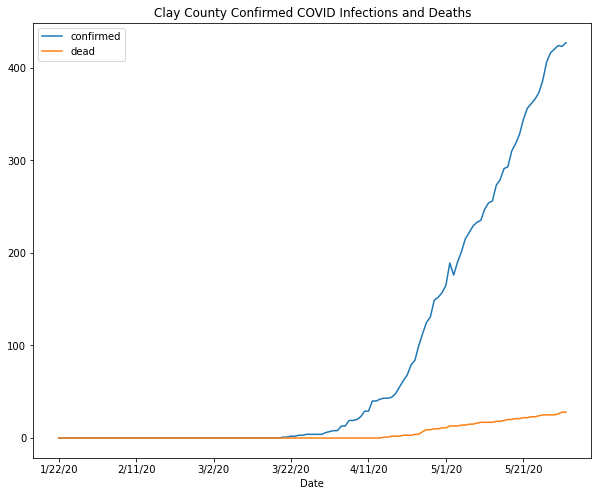

In [8]:
##
## Load the time series datafiles to experiment with them.  These only contain Deaths and Confirmed cases,
## so I suspect we won't keep them, since I build the same data from the daily files above.
##

# Create pandas dataframes containing time-series data (We could reconstruct this by looping through all the daily data, since this is missing number of recovered)
ts_us_dead_df = pd.read_csv(ts_us_dead_csv)            # Deaths in time series
ts_us_confirmed_df = pd.read_csv(ts_us_confirmed_csv)  # Confirmed in time series

# We could transpose the dataframe to allow easier extraction of time series data on a per county level
tmp_df = ts_us_confirmed_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "confirmed" }, inplace = True)
confirmed_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')]  # Use pattern matching to find real dates and include

tmp_df = ts_us_dead_df[ (ts_us_confirmed_df['Province_State'] == 'Minnesota') & (ts_us_confirmed_df['Admin2'] == 'Clay') ].T
tmp_df.rename(columns={ tmp_df.columns[0]: "dead" }, inplace = True)
dead_clay = tmp_df[tmp_df.index.str.match('[0-9]*/[0-9]*/[0-9]*')] # Use pattern matching to find real dates and include

# Merge the confirmed ill and dead into one dataframe (would like recovered too, but that's not in
# these times series files).  
merged_clay = confirmed_clay.merge(dead_clay, left_index=True, right_index=True)
plot = merged_clay.plot(figsize=(10,8))
xlabel = plt.xlabel('Date')
ylabel = plt.title('Confirmed COVID Infections and Deaths')
title = plt.title('Clay County Confirmed COVID Infections and Deaths')

# NOTE: This is using PANDAS to do the plotting, it will be a lot more flexible to extra data from Pandas and then
# use matplotlib to make the plots.  For one thing, we could add labels to the plot more easily.

In [9]:
##
## This is mostly just showing I can just grab a single dataset for the most recent daily data instead of 
## trying to grab everything and put it all together.  However, this only allows printing some data
##

# Grab complete list of all csvs to then...
world_csvs = list(csvfiles(daily_cnty_dir))
us_csvs = list(csvfiles(daily_state_dir))

# .. grab the most recent CSV file to open the data.
daily_world_csv = daily_cnty_dir+world_csvs[-1]
daily_us_csv = daily_state_dir+us_csvs[-1]

# Create pandas dataframes containing the daily data from the CSV files 
# (contains number of confirmed/deaths/recovered on that date)
daily_world_df = pd.read_csv(daily_world_csv)   # County/Admin totals
daily_us_df = pd.read_csv(daily_us_csv)         # State totals

# Print county data to screen
print("LOCAL COUNTY DATA IN daily_world_df() DATAFRAME")
print(daily_world_df[ (daily_world_df['FIPS'] == ClayFIPS) | (daily_world_df['FIPS'] == CassFIPS) ])

# Print state level data to screen (which has data on testing and hospitalization rates)
print("\nLOCAL STATE DATA IN daily_us_df() DATAFRAME")
print(daily_us_df[ (daily_us_df['FIPS'] == MNFIPS) | (daily_us_df['FIPS'] == NDFIPS) ])

LOCAL COUNTY DATA IN daily_world_df() DATAFRAME
        FIPS Admin2 Province_State Country_Region          Last_Update  \
400  38017.0   Cass   North Dakota             US  2020-06-02 02:33:08   
521  27027.0   Clay      Minnesota             US  2020-06-02 02:33:08   

           Lat      Long_  Confirmed  Deaths  Recovered  Active  \
400  46.932017 -97.244472       1744      44          0    1700   
521  46.892895 -96.487619        427      28          0     399   

               Combined_Key  Incidence_Rate  Case-Fatality_Ratio  
400  Cass, North Dakota, US      958.647340             2.522936  
521     Clay, Minnesota, US      664.881193             6.557377  

LOCAL STATE DATA IN daily_us_df() DATAFRAME
   Province_State Country_Region          Last_Update      Lat    Long_  \
27      Minnesota             US  2020-06-02 02:33:16  45.6945 -93.9002   
38   North Dakota             US  2020-06-02 02:33:16  47.5289 -99.7840   

    Confirmed  Deaths  Recovered  Active  FIPS  Inciden

In [10]:
##
## Build combined county-level datafiles
##

# Build a dataframe containing legitimate FIPS values using county level data
fips_df = county_data_df.copy()
fips_df.drop(columns=['STNAME', 'CTYNAME', 'POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)

# Scan through the more complete daily files of county level data and construct a single datafile for our use (restricting 
# to US only).  It turns out the format of these local level files changes with the date.  The files before March 22, 2020 
# were in several different forms and the placenames were NOT consistent.  Thus, to make things managable, I am ignoring
# that early local level data...
sorted_csvs = []
dates_list = []
for file in csvfiles(daily_cnty_dir):
    # County level date only starts on March 22, before then it is a mis-mosh of place names in the Province_State field
    # So only keep that data
    this_isodate = isodate2num(file)
    this_date = date2num(file)
    if (int(this_date) >= 20200322):
        # Append to list of accessed csv files
        sorted_csvs.append(daily_cnty_dir+file)

        # Grab the data from the CSV file
        raw_df = pd.read_csv(sorted_csvs[-1])

        # Rename columns in early forms to late forms of column names for consistency
        raw_df.rename(columns={ 'Province/State': 'Province_State', 
                               'Country/Region':'Country_Region', 
                               'Last Update':'Last_Update' }, inplace = True)
        
        # Match to the list of known FIPS values from Census data, also removing duplicate rows
        reduced_df = reduce_local_dataframe(raw_df, fips_df)
        
        # Provide progress report
        idx = len(sorted_csvs)
        # print(f'Processing Date #{idx}: {this_isodate}')
        
        if (idx == 1):
            # Create combined dataframe sorted by FIPS
            combined_cols = ['FIPS', 'Admin2', 'Province_State', 'Lat', 'Long_']
            combined_cnty_df = reduced_df[combined_cols].copy()
        
            # Create blank dataframes to store time series data
            confirmed_df = fips_df.copy()
            deaths_df = fips_df.copy()
            recovered_df = fips_df.copy()
            
        ## Create dataframes for temporarily storing time series date
        # Append date to list of dates
        dates_list.append(this_isodate)
            
        # Store Confirmed by merging reduced list and renaming column
        confirmed_df = pd.merge(confirmed_df,reduced_df[['FIPS','Confirmed']],on='FIPS', how='left', copy=True)
        confirmed_col = "C"+f"{idx:03d}"
        confirmed_df.rename(columns={'Confirmed': confirmed_col}, errors="raise", inplace=True)
        
        # Store Deaths by merging reduced list and renaming column
        deaths_df = pd.merge(deaths_df,reduced_df[['FIPS','Deaths']],on='FIPS', how='left', copy=True)
        deaths_col = "D"+f"{idx:03d}"
        deaths_df.rename(columns={'Deaths': deaths_col}, errors="raise", inplace=True)
        
        # Store Recovered by merging reduced list and renaming column
        recovered_df = pd.merge(recovered_df,reduced_df[['FIPS','Recovered']],on='FIPS', how='left', copy=True)
        recovered_col = "R"+f"{idx:03d}"
        recovered_df.rename(columns={'Recovered': recovered_col}, errors="raise", inplace=True)
            
# Final cleanup (convert to integers and remove NaN for the confirmed and deaths [don't touch recovered yet])
confirmed_df = confirmed_df.replace(np.nan,0).astype('int')
deaths_df= deaths_df.replace(np.nan,0).astype('int')

# Add lists of dates to the combined dataframe as a single 'Dates' column
combined_cnty_df['Dates'] = [dates_list]*len(combined_cnty_df)
# Add time-series list of confirmed to the combined dataframe as a single 'Confirmed' column
confirmed_listOlists = confirmed_df[ confirmed_df.columns[confirmed_df.columns!='FIPS'] ].values.tolist()
combined_cnty_df['Confirmed'] = confirmed_listOlists
# Add time-series list of deaths to the combined dataframe as a single 'Deaths' column
deaths_listOlists = deaths_df[ deaths_df.columns[deaths_df.columns!='FIPS'] ].values.tolist()
combined_cnty_df['Deaths'] = deaths_listOlists
# Add time-series list of recovered to the combined dataframe as a single 'Recovered' column
recovered_listOlists = recovered_df[ recovered_df.columns[recovered_df.columns!='FIPS'] ].values.tolist()
combined_cnty_df['Recovered'] = recovered_listOlists

# Convert the list of dates into numpy array of days since Jan. 1, 2020 for each observation
dates = combined_cnty_df[combined_cnty_df['FIPS'] == ClayFIPS]['Dates'].tolist()[0]
dates_list = []
for dat in dates:
    dates_list.append( iso2days(dat) )
dates_arr = np.array([dates_list]*len(combined_cnty_df))

# Convert confirmed/deaths/recovered into arrays
confirmed_arr = np.array(confirmed_listOlists)
deaths_arr = np.array(deaths_listOlists)

# At this point I have arrays where the rows are individiual FIPS (counties) and the columns are 
# (depending on the array) the days since 1/1/2020, number of confirmed cases, number of deaths, 
# and number of recovered.

# Compute the derivatives (using forward derivative approach)
dconfirmed_arr = derivative(dates_arr, confirmed_arr)
ddeaths_arr = derivative(dates_arr, deaths_arr)

# Compute the second derivatives (a bit hinky to use forward derivative again, but...)
d2confirmed_arr = derivative(dates_arr, dconfirmed_arr)
d2deaths_arr = derivative(dates_arr, ddeaths_arr)

# Convert numpy arrays to lists of lists for storage in combined dataframe
combined_cnty_df['dConfirmed'] = dconfirmed_arr.tolist()
combined_cnty_df['d2Confirmed'] = d2confirmed_arr.tolist()
combined_cnty_df['dDeaths'] = ddeaths_arr.tolist()
combined_cnty_df['d2Deaths'] = d2deaths_arr.tolist()

# Add population data to same array
combined_cnty_df = pd.merge(combined_cnty_df,county_data_df[['FIPS','POPESTIMATE2019', 'NPOPCHG_2019']], on='FIPS', how='left', copy=True)

# Rename some columns before export
combined_cnty_df.rename(columns={ 'Admin2': 'County', 
                                 'Province_State': 'State', 
                                  'POPESTIMATE2019' : 'PopEst2019',
                                  'NPOPCHG_2019' : 'PopChg2019'}, inplace = True)

# Save the processed time-series data into single file
combined_datafile = data_dir + "countylevel_combinedCDR.csv"
combined_cnty_df.to_csv(combined_datafile, index=False)

# Clear variables
del sorted_csvs, dates_list
del fips_df, raw_df, confirmed_df, deaths_df, recovered_df
del confirmed_listOlists, deaths_listOlists, recovered_listOlists
del dates_arr, confirmed_arr, deaths_arr
del dconfirmed_arr, ddeaths_arr, d2confirmed_arr, d2deaths_arr

In [11]:
print("COMBINED DAILY DATA IN combined_cnty_df() DATAFRAME")
print(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS) | (combined_cnty_df['FIPS'] == CassFIPS)])

COMBINED DAILY DATA IN combined_cnty_df() DATAFRAME
       FIPS County         State        Lat      Long_  \
1327  27027   Clay     Minnesota  46.892895 -96.487619   
1998  38017   Cass  North Dakota  46.932017 -97.244472   

                                                  Dates  \
1327  [2020-03-22, 2020-03-23, 2020-03-24, 2020-03-2...   
1998  [2020-03-22, 2020-03-23, 2020-03-24, 2020-03-2...   

                                              Confirmed  \
1327  [2, 2, 3, 3, 4, 4, 4, 4, 4, 6, 7, 8, 8, 13, 13...   
1998  [1, 1, 3, 6, 6, 11, 18, 20, 24, 32, 34, 43, 46...   

                                                 Deaths  \
1327  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1998  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                              Recovered  \
1327  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1998  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                             dConfirmed  \
13

In [12]:
##
## Build combined state-level datafiles
##

# Build a dataframe containing legitimate FIPS values using county level data
fips_df = state_data_df.copy()
fips_df.drop(columns=['STNAME', 'POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)

# Scan through the more complete daily files of state level data and construct a single datafile for our use (restricting 
# to US only).  These files are all the same format, but only start after April 12, 2020.  For April 18/19 they accidentally
# included data from other nations.  So this will need to be purged
sorted_csvs = []
dates_list = []
for file in csvfiles(daily_state_dir):
    # Set up date information in memory
    this_isodate = isodate2num(file)
    
    # Append to list of accessed csv files
    sorted_csvs.append(daily_state_dir+file)

    # Grab the data from the CSV file
    raw_df = pd.read_csv(sorted_csvs[-1])
    
    # Match to the list of known FIPS values from Census data, also removing duplicate rows
    reduced_df = reduce_local_dataframe(raw_df, fips_df)
        
    # Provide progress report
    idx = len(sorted_csvs)
    # print(f'Processing Date #{idx}: {this_isodate}')
        
    if (idx == 1):
        # Create combined dataframe sorted by FIPS
        combined_cols = ['FIPS', 'Province_State', 'Lat', 'Long_']
        combined_state_df = reduced_df[combined_cols].copy()
        
        # Create blank dataframes to store time series data
        confirmed_df = fips_df.copy()
        deaths_df = fips_df.copy()
        recovered_df = fips_df.copy()
        incident_rate_df = fips_df.copy()
        tested_df = fips_df.copy()
        hospitalized_df = fips_df.copy()
        mortality_df = fips_df.copy()
        testing_rate_df = fips_df.copy()
        hospitalization_rate_df = fips_df.copy()
            
    ## Create dataframes for temporarily storing time series date
    # Append date to list of dates
    dates_list.append(this_isodate)
    
    # Store Confirmed by merging reduced list and renaming column
    confirmed_df = pd.merge(confirmed_df,reduced_df[['FIPS','Confirmed']],on='FIPS', how='left', copy=True)
    confirmed_col = "C"+f"{idx:03d}"
    confirmed_df.rename(columns={'Confirmed': confirmed_col}, errors="raise", inplace=True)
        
    # Store Deaths by merging reduced list and renaming column
    deaths_df = pd.merge(deaths_df,reduced_df[['FIPS','Deaths']],on='FIPS', how='left', copy=True)
    deaths_col = "D"+f"{idx:03d}"
    deaths_df.rename(columns={'Deaths': deaths_col}, errors="raise", inplace=True)
        
    # Store Recovered by merging reduced list and renaming column
    recovered_df = pd.merge(recovered_df,reduced_df[['FIPS','Recovered']],on='FIPS', how='left', copy=True)
    recovered_col = "R"+f"{idx:03d}"
    recovered_df.rename(columns={'Recovered': recovered_col}, errors="raise", inplace=True)
        
    # Store Incident Rate by merging reduced list and renaming column
    incident_rate_df = pd.merge(incident_rate_df,reduced_df[['FIPS','Incident_Rate']],on='FIPS', how='left', copy=True)
    incident_rate_col = "I"+f"{idx:03d}"
    incident_rate_df.rename(columns={'Incident_Rate': incident_rate_col}, errors="raise", inplace=True)
        
    # Store People Testing by merging reduced list and renaming column
    tested_df = pd.merge(tested_df,reduced_df[['FIPS','People_Tested']],on='FIPS', how='left', copy=True)
    tested_col = "T"+f"{idx:03d}"
    tested_df.rename(columns={'People_Tested': tested_col}, errors="raise", inplace=True)
    
    # Store People Hospitalized by merging reduced list and renaming column
    hospitalized_df = pd.merge(hospitalized_df,reduced_df[['FIPS','People_Hospitalized']],on='FIPS', how='left', copy=True)
    hospitalized_col = "H"+f"{idx:03d}"
    hospitalized_df.rename(columns={'People_Hospitalized': hospitalized_col}, errors="raise", inplace=True)

    # Store Mortality Rate by merging reduced list and renaming column
    mortality_df = pd.merge(mortality_df,reduced_df[['FIPS','Mortality_Rate']],on='FIPS', how='left', copy=True)
    mortality_col = "M"+f"{idx:03d}"
    mortality_df.rename(columns={'Mortality_Rate': mortality_col}, errors="raise", inplace=True)
    
    # Store Testing Rate by merging reduced list and renaming column
    testing_rate_df = pd.merge(testing_rate_df,reduced_df[['FIPS','Testing_Rate']],on='FIPS', how='left', copy=True)
    testing_rate_col = "T"+f"{idx:03d}"
    testing_rate_df.rename(columns={'Testing_Rate': testing_rate_col}, errors="raise", inplace=True)
    
    # Store Hospitalization Rate by merging reduced list and renaming column
    hospitalization_rate_df = pd.merge(hospitalization_rate_df,reduced_df[['FIPS','Hospitalization_Rate']],on='FIPS', how='left', copy=True)
    hospitalization_rate_col = "H"+f"{idx:03d}"
    hospitalization_rate_df.rename(columns={'Hospitalization_Rate': hospitalization_rate_col}, errors="raise", inplace=True)
    
# Final cleanup (convert values that are integers to to integers)
confirmed_df = confirmed_df.replace(np.nan,0).astype('int')
deaths_df = deaths_df.replace(np.nan,0).astype('int')

# Add lists of dates to the combined dataframe as a single 'Dates' column
combined_state_df['Dates'] = [dates_list]*len(combined_state_df)
# Add time-series list of confirmed to the combined dataframe as a single 'Confirmed' column
confirmed_listOlists = confirmed_df[ confirmed_df.columns[confirmed_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Confirmed'] = confirmed_listOlists
# Add time-series list of deaths to the combined dataframe as a single 'Deaths' column
deaths_listOlists = deaths_df[ deaths_df.columns[deaths_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Deaths'] = deaths_listOlists
# Add time-series list of recovered to the combined dataframe as a single 'Recovered' column
recovered_listOlists = recovered_df[ recovered_df.columns[recovered_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Recovered'] = recovered_listOlists
# Add time-series list of incident rate to the combined dataframe as a single 'Incident_Rate' column
incident_rate_listOlists = incident_rate_df[ incident_rate_df.columns[incident_rate_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Incident_Rate'] = incident_rate_listOlists
# Add time-series list of people tested to the combined dataframe as a single 'People_Tested' column
tested_listOlists = tested_df[ tested_df.columns[tested_df.columns!='FIPS'] ].values.tolist()
combined_state_df['People_Tested'] = tested_listOlists
# Add time-series list of people hospitalized to the combined dataframe as a single 'People_Hospitalized' column
hospitalized_listOlists = hospitalized_df[ hospitalized_df.columns[hospitalized_df.columns!='FIPS'] ].values.tolist()
combined_state_df['People_Hospitalized'] = hospitalized_listOlists
# Add time-series list of mortality rates to the combined dataframe as a single 'Mortality_Rate' column
mortality_listOlists = mortality_df[ mortality_df.columns[mortality_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Mortality_Rate'] = mortality_listOlists
# Add time-series list of testing rates to the combined dataframe as a single 'Testing_Rate' column
testing_rate_listOlists = testing_rate_df[ testing_rate_df.columns[testing_rate_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Testing_Rate'] = testing_rate_listOlists
# Add time-series list of hospitalization rates to the combined dataframe as a single 'Hospitalization_Rate' column
hospitalization_rate_listOlists = hospitalization_rate_df[ hospitalization_rate_df.columns[hospitalization_rate_df.columns!='FIPS'] ].values.tolist()
combined_state_df['Hospitalization_Rate'] = hospitalization_rate_listOlists

# Convert the list of dates into numpy array of days since Jan. 1, 2020 for each observation
dates = combined_state_df[combined_state_df['FIPS'] == MNFIPS]['Dates'].tolist()[0]
dates_list = []
for dat in dates:
    dates_list.append( iso2days(dat) )
dates_arr = np.array([dates_list]*len(combined_state_df))

# Convert confirmed/deaths/recovered into arrays
confirmed_arr = np.array(confirmed_listOlists)
deaths_arr = np.array(deaths_listOlists)

# At this point I have arrays where the rows are individiual FIPS (counties) and the columns are 
# (depending on the array) the days since 1/1/2020, number of confirmed cases, number of deaths, 
# and number of recovered.

# Compute the derivatives (using forward derivative approach)
dconfirmed_arr = derivative(dates_arr, confirmed_arr)
ddeaths_arr = derivative(dates_arr, deaths_arr)

# Compute the second derivatives (a bit hinky to use forward derivative again, but...)
d2confirmed_arr = derivative(dates_arr, dconfirmed_arr)
d2deaths_arr = derivative(dates_arr, ddeaths_arr)

# Convert numpy arrays to lists of lists for storage in combined dataframe
combined_state_df['dConfirmed'] = dconfirmed_arr.tolist()
combined_state_df['d2Confirmed'] = d2confirmed_arr.tolist()
combined_state_df['dDeaths'] = ddeaths_arr.tolist()
combined_state_df['d2Deaths'] = d2deaths_arr.tolist()

# Add population data to same array
combined_state_df = pd.merge(combined_state_df,state_data_df[['FIPS','POPESTIMATE2019', 'NPOPCHG_2019']], on='FIPS', how='left', copy=True)

# Rename some columns before export
combined_state_df.rename(columns={ 'Province_State': 'State', 
                                  'POPESTIMATE2019' : 'PopEst2019',
                                  'NPOPCHG_2019' : 'PopChg2019'}, inplace = True)

# Save the processed time-series data into single file
combined_datafile = data_dir + "statelevel_combinedCDR.csv"
combined_state_df.to_csv(combined_datafile, index=False)

# Clear variables
del sorted_csvs, dates_list
del fips_df, raw_df, confirmed_df, deaths_df, recovered_df
del confirmed_listOlists, deaths_listOlists, recovered_listOlists, incident_rate_listOlists
del tested_listOlists, hospitalized_listOlists, mortality_listOlists, testing_rate_listOlists, hospitalization_rate_listOlists
del dates_arr, confirmed_arr, deaths_arr
del dconfirmed_arr, ddeaths_arr, d2confirmed_arr, d2deaths_arr

In [13]:
print("COMBINED DAILY DATA IN combined_state_df() DATAFRAME")
print(combined_state_df[(combined_state_df['FIPS'] == MNFIPS) | (combined_state_df['FIPS'] == NDFIPS)])

COMBINED DAILY DATA IN combined_state_df() DATAFRAME
    FIPS         State      Lat    Long_  \
23    27     Minnesota  45.6945 -93.9002   
34    38  North Dakota  47.5289 -99.7840   

                                                Dates  \
23  [2020-04-12, 2020-04-13, 2020-04-14, 2020-04-1...   
34  [2020-04-12, 2020-04-13, 2020-04-14, 2020-04-1...   

                                            Confirmed  \
23  [1621, 1621, 1695, 1809, 1809, 2070, 2209, 235...   
34  [308, 331, 341, 365, 393, 393, 528, 585, 627, ...   

                                               Deaths  \
23  [70, 70, 79, 87, 87, 111, 121, 134, 143, 160, ...   
34  [7, 8, 8, 9, 9, 9, 9, 9, 9, 13, 14, 15, 15, 16...   

                                            Recovered  \
23  [842.0, 842.0, 909.0, 940.0, 1020.0, 1066.0, 1...   
34  [121.0, 127.0, 138.0, 142.0, 163.0, 172.0, 183...   

                                        Incident_Rate  \
23  [32.77100367, 32.771003666066505, 34.26702728,...   
34  [50.7900

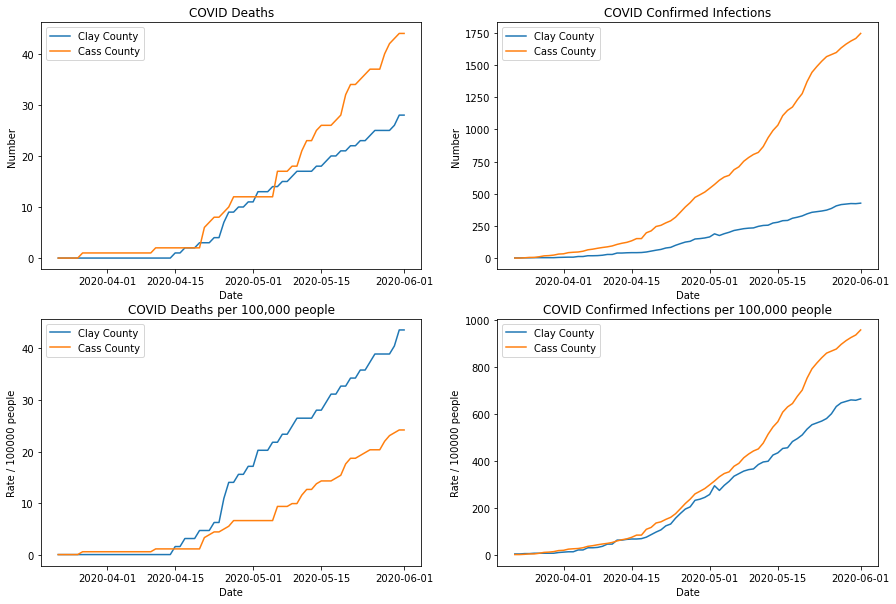

In [14]:
# Show demonstrations of plotting this data here by producing plots of data for Cass and Clay counties and North Dakota and Minnesota

#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# County-level data for plotting
dates_cty = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Dates'].to_list()[0], dtype='datetime64')
clay_deaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Deaths'].to_list()[0],dtype='int')
clay_death_rate = (clay_deaths/combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['PopEst2019'].values)*100000
cass_deaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['Deaths'].to_list()[0],dtype='int')
cass_death_rate = (cass_deaths/combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['PopEst2019'].values)*100000
clay_confirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Confirmed'].to_list()[0],dtype='int')
clay_confirmed_rate = (clay_confirmed/combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['PopEst2019'].values)*100000
cass_confirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['Confirmed'].to_list()[0],dtype='int')
cass_confirmed_rate = (cass_confirmed/combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['PopEst2019'].values)*100000

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Plot up deaths and death rates as plots 0 and 1
this_axs = axs[0, 0]  # Row 0, column 0
this_axs.plot(dates_cty, clay_deaths, label='Clay County')
this_axs.plot(dates_cty, cass_deaths, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Deaths")

this_axs = axs[1, 0]  # Row 1, column 0
this_axs.plot(dates_cty, clay_death_rate, label='Clay County')
this_axs.plot(dates_cty, cass_death_rate, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Deaths per 100,000 people")

# Plot up confirmed infections and infection rates as plots 2 and 3
this_axs = axs[0, 1]  # Row 0, column 1
this_axs.plot(dates_cty, clay_confirmed, label='Clay County')
this_axs.plot(dates_cty, cass_confirmed, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Confirmed Infections")

this_axs = axs[1, 1]  # Row 1, column 1
this_axs.plot(dates_cty, clay_confirmed_rate, label='Clay County')
this_axs.plot(dates_cty, cass_confirmed_rate, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Confirmed Infections per 100,000 people")

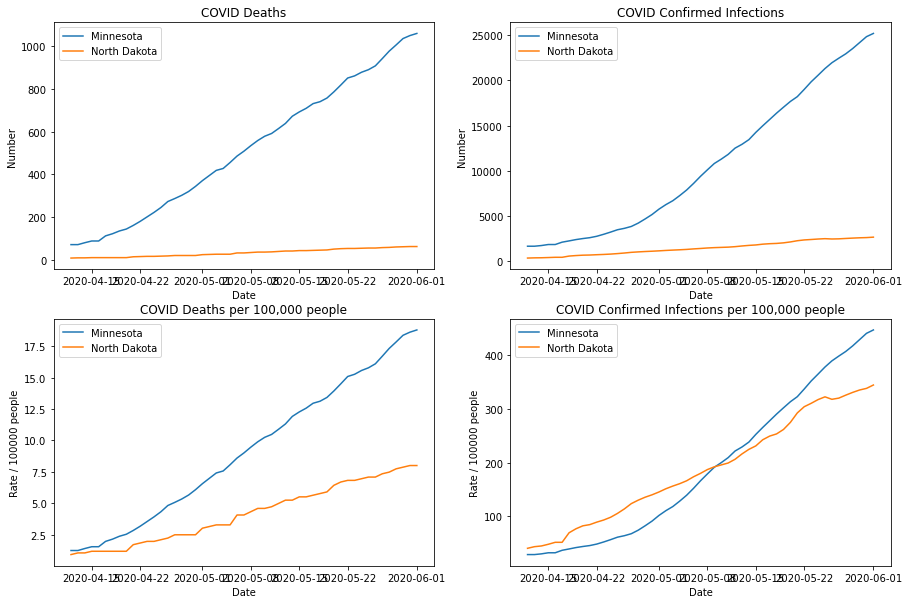

In [15]:
#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# State-level data for plotting
dates_state = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Dates'].to_list()[0], dtype='datetime64')
MN_deaths = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Deaths'].to_list()[0],dtype='int')
MN_death_rate = (MN_deaths/combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['PopEst2019'].values)*100000
ND_deaths = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['Deaths'].to_list()[0],dtype='int')
ND_death_rate = (ND_deaths/combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['PopEst2019'].values)*100000
MN_confirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Confirmed'].to_list()[0],dtype='int')
MN_confirmed_rate = (MN_confirmed/combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['PopEst2019'].values)*100000
ND_confirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['Confirmed'].to_list()[0],dtype='int')
ND_confirmed_rate = (ND_confirmed/combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['PopEst2019'].values)*100000

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Plot up deaths and death rates as plots 0 and 1
this_axs = axs[0, 0]  # Row 0, column 0
this_axs.plot(dates_state, MN_deaths, label='Minnesota')
this_axs.plot(dates_state, ND_deaths, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Deaths")

this_axs = axs[1, 0]  # Row 1, column 0
this_axs.plot(dates_state, MN_death_rate, label='Minnesota')
this_axs.plot(dates_state, ND_death_rate, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Deaths per 100,000 people")

# Plot up confirmed infections and infection rates as plots 2 and 3
this_axs = axs[0, 1]  # Row 0, column 1
this_axs.plot(dates_state, MN_confirmed, label='Minnesota')
this_axs.plot(dates_state, ND_confirmed, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Number")
title = this_axs.set_title("COVID Confirmed Infections")

this_axs = axs[1, 1]  # Row 1, column 1
this_axs.plot(dates_state, MN_confirmed_rate, label='Minnesota')
this_axs.plot(dates_state, ND_confirmed_rate, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("Rate / 100000 people")
title = this_axs.set_title("COVID Confirmed Infections per 100,000 people")

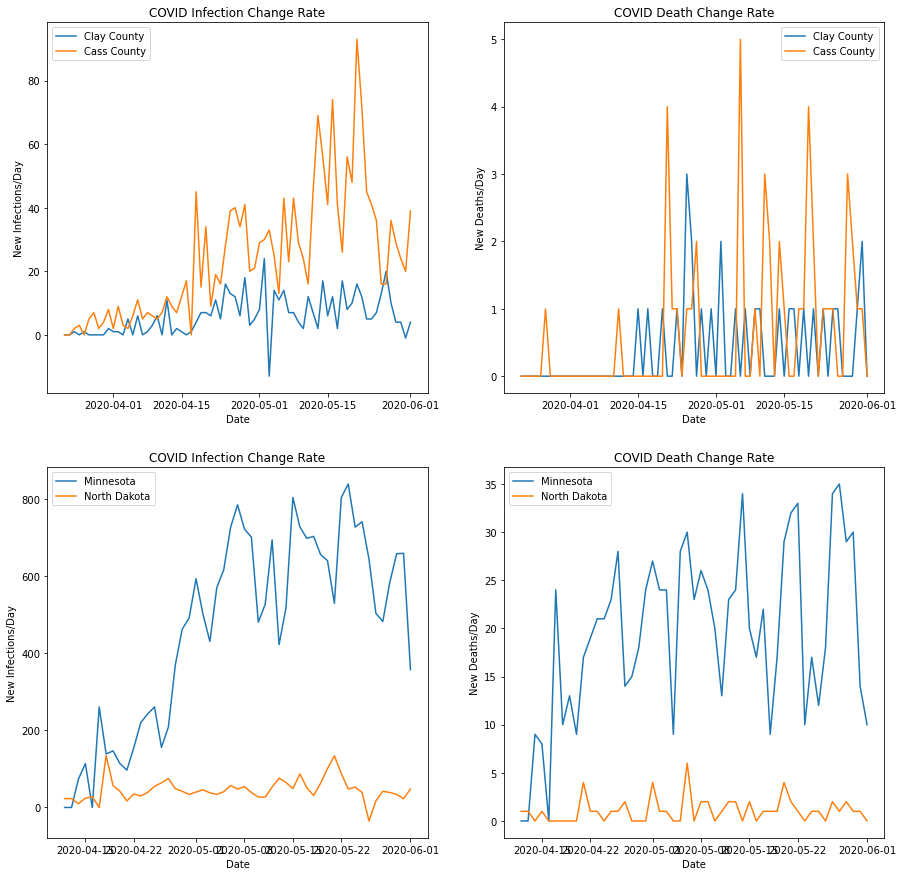

In [16]:
# Show demonstrations of plotting this data here by producing plots of data for Cass and Clay counties and North Dakota and Minnesota

#
# I will pull the data to plot into numpy arrays (notice I have to use [0] because it comes out at list of lists even for single row)
#

# County-level data for plotting
dates_cty = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['Dates'].to_list()[0], dtype='datetime64')
clay_ddeaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['dDeaths'].to_list()[0])
cass_ddeaths = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['dDeaths'].to_list()[0])
clay_dconfirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == ClayFIPS)]['dConfirmed'].to_list()[0])
cass_dconfirmed = np.array(combined_cnty_df[(combined_cnty_df['FIPS'] == CassFIPS)]['dConfirmed'].to_list()[0])

# State-level data for plotting
dates_state = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['Dates'].to_list()[0], dtype='datetime64')
MN_ddeaths = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['dDeaths'].to_list()[0])
ND_ddeaths = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['dDeaths'].to_list()[0])
MN_dconfirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == MNFIPS)]['dConfirmed'].to_list()[0])
ND_dconfirmed = np.array(combined_state_df[(combined_state_df['FIPS'] == NDFIPS)]['dConfirmed'].to_list()[0])

# Set up a figure of 2 x 2 plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot up the deriviates in the infection and death rates for counties
this_axs = axs[0, 0]  # row 0, column 0
this_axs.plot(dates_cty, clay_dconfirmed, label='Clay County')
this_axs.plot(dates_cty, cass_dconfirmed, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Infections/Day")
title = this_axs.set_title("COVID Infection Change Rate")

this_axs = axs[0, 1]  # row 0, column 1
this_axs.plot(dates_cty, clay_ddeaths, label='Clay County')
this_axs.plot(dates_cty, cass_ddeaths, label='Cass County')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Deaths/Day")
title = this_axs.set_title("COVID Death Change Rate")

# Plot up the deriviates in the infection and death rates for states
this_axs = axs[1, 0]  # row 1, column 0
this_axs.plot(dates_state, MN_dconfirmed, label='Minnesota')
this_axs.plot(dates_state, ND_dconfirmed, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Infections/Day")
title = this_axs.set_title("COVID Infection Change Rate")

this_axs = axs[1, 1]  # row 1, column 1
this_axs.plot(dates_state, MN_ddeaths, label='Minnesota')
this_axs.plot(dates_state, ND_ddeaths, label='North Dakota')
legend = this_axs.legend()
xlabel = this_axs.set_xlabel("Date")
ylabel = this_axs.set_ylabel("New Deaths/Day")
title = this_axs.set_title("COVID Death Change Rate")

# Next few blocks of code is grabbing the Google and Apple mobility data and cross-matching with US Census Bureau FIPS data

## Google Mobility Data (NO FIPS Present)

This data is described at https://www.google.com/covid19/mobility/ and can be downloaded in a single monolithic CSV file at https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

> The data shows how visitors to (or time spent in) categorized places change compared to our baseline days. A baseline day represents a normal value for that day of the week. The baseline day is the median value from the 5‑week period Jan 3 – Feb 6, 2020.

> For each region-category, the baseline isn’t a single value—it’s 7 individual values. The same number of visitors on 2 different days of the week, result in different percentage changes. So, we recommend the following:
1. Don’t infer that larger changes mean more visitors or smaller changes mean less visitors.
2. Avoid comparing day-to-day changes. Especially weekends with weekdays. (https://support.google.com/covid19-mobility/answer/9824897?hl=en&ref_topic=9822927)

> Note, *Parks* typically means official national parks and not the general outdoors found in rural areas.

Also, I'll note that aggregated national data appears to be available by setting `sub_region_1` **and** `sub_region_2` to `NaN` and state-level data by setting only `sub_region_2` to `NaN`.

In [17]:
# Google Mobility Data URL
goog_mobility_csv_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
goog_mobility_df=pd.read_csv(goog_mobility_csv_url, low_memory=False)

## Separate data into national-level, state-level, and county-level data deep copies
goog_mobility_national = goog_mobility_df[(goog_mobility_df['country_region_code'] == 'US') & (goog_mobility_df['sub_region_1'].isna()) & (goog_mobility_df['sub_region_2'].isna())].copy()
goog_mobility_states = goog_mobility_df[(goog_mobility_df['country_region_code'] == 'US') & (goog_mobility_df['sub_region_1'].notna()) & (goog_mobility_df['sub_region_2'].isna())].copy()
goog_mobility_cnty = goog_mobility_df[(goog_mobility_df['country_region_code'] == 'US') & (goog_mobility_df['sub_region_1'].notna()) & (goog_mobility_df['sub_region_2'].notna())].copy()

# District of Columbia is both FIPS 11 and FIPS 110, so add its data to county-level mobility data
dc_rows = goog_mobility_states[goog_mobility_states['sub_region_1'] == 'District of Columbia'].copy()
dc_rows['sub_region_2'] = dc_rows['sub_region_1']
goog_mobility_cnty = goog_mobility_cnty.append(dc_rows, ignore_index=True)

# Notice for Clay county we have NaN reported for Parks (see note above) and Transit Stations
goog_mobility_clay = goog_mobility_df[ (goog_mobility_df['sub_region_1'] == 'Minnesota') & (goog_mobility_df['sub_region_2'] == 'Clay County')]
print("FIRST ROW OF GOOGLE MOBILITY DATA IN goog_mobility_df() FOR CLAY COUNTY")
print(goog_mobility_clay.iloc[[0]])

# Undefine the clay county subframe
del goog_mobility_clay
del goog_mobility_df

FIRST ROW OF GOOGLE MOBILITY DATA IN goog_mobility_df() FOR CLAY COUNTY
       country_region_code country_region sub_region_1 sub_region_2  \
294231                  US  United States    Minnesota  Clay County   

              date  retail_and_recreation_percent_change_from_baseline  \
294231  2020-02-15                                                9.0    

        grocery_and_pharmacy_percent_change_from_baseline  \
294231                                                5.0   

        parks_percent_change_from_baseline  \
294231                                 NaN   

        transit_stations_percent_change_from_baseline  \
294231                                            NaN   

        workplaces_percent_change_from_baseline  \
294231                                     -1.0   

        residential_percent_change_from_baseline  
294231                                       NaN  


In [18]:
##
## Cross match known US Bureau Census FIPS entries with Google Mobility Data here to allow easier cross-matching later.
##

# Build a dataframe containing legitimate FIPS values using state and county level data
state_fips_df = state_data_df.copy()
state_fips_df.drop(columns=['POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)
cnty_fips_df = county_data_df.copy()
cnty_fips_df.drop(columns=['POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)

## Match state-level mobility data to FIPS and then drop redundant columns and rename state name to be consistent.  
goog_mobility_states_reduced = pd.merge(state_fips_df,goog_mobility_states,left_on='STNAME', right_on='sub_region_1', how='left', copy=True)
goog_mobility_states_reduced.drop(columns=['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2'], inplace=True)
goog_mobility_states_reduced.rename(columns={ 'STNAME': 'tate'}, inplace = True)

##
## Match county-level mobility data to FIPS (trickier as it requires a state and county name match
##

# Comparing the unique county names in cnty_fips_df['CTYNAME_MATCH'] versus goog_mobility_cnty['sub_region_2'] reveals a lot of mismatching is due to 
# US Census bureau naming convention including 
#  ' city' (for cities that are also counties [40 cases]) [This allows matching of Baltimore city versus Baltimore county also]
#  ' Municipality' (for cities that are also counties)
#  ' Census Area' (for rural areas, I think)
cnty_fips_df['CTYNAME_MATCH'] = cnty_fips_df['CTYNAME']
cnty_fips_df['CTYNAME_MATCH'] = cnty_fips_df['CTYNAME_MATCH'].str.replace(' city','')
cnty_fips_df['CTYNAME_MATCH'] = cnty_fips_df['CTYNAME_MATCH'].str.replace(' Municipality','')
cnty_fips_df['CTYNAME_MATCH'] = cnty_fips_df['CTYNAME_MATCH'].str.replace(' Census Area','')
cnty_fips_df['CTYNAME_MATCH'] = cnty_fips_df['CTYNAME_MATCH'].str.replace(' City and Borough','')
cnty_fips_df['CTYNAME_MATCH'] = cnty_fips_df['CTYNAME_MATCH'].str.replace(' Borough','')

goog_mobility_cnty['sub_region_2_MATCH'] = goog_mobility_cnty['sub_region_2']
goog_mobility_cnty['sub_region_2_MATCH'] = goog_mobility_cnty['sub_region_2_MATCH'].str.replace(' Borough','')
# Fix alternate spelling of LaSalle Parish, Louisiana
goog_mobility_cnty['sub_region_2_MATCH'] = goog_mobility_cnty['sub_region_2_MATCH'].str.replace('La Salle Parish','LaSalle Parish')

# A lot of rural areas just appear to have no data in the Google Mobility dataset. The next cell (commented out) was used to confirm the only missing counies
# were ones in which there was 'nan' for the date column, indicating no matches in the Google Mobility dataset.

## This leftward match means EVERY county FIPS should still be represented, although need to confirm mismatches
goog_mobility_cnty_reduced = pd.merge(cnty_fips_df,goog_mobility_cnty,left_on=['STNAME', 'CTYNAME_MATCH'], right_on=['sub_region_1', 'sub_region_2_MATCH'], how='left', copy=True)

##
## Check the date column in the reduced data to see if it is a real match or just a marker for a non-match
##


In [19]:
# As a test, loop through all the county FIPS codes and see which are NOT represented in the mobility data
unmatched_cnt = 0
cleared_states = [] 
states_list = []
last_state = 'Alaska' # Set to avoid issue in loop below with undefined variable

fatal_error = 0. # Count fatal_error and stop if we have any
cnt = 0
bad_entries = ""
for FIPS in cnty_fips_df['FIPS']:
    # Check this FIPS number
    rows = goog_mobility_cnty_reduced[goog_mobility_cnty_reduced['FIPS'] == FIPS]
    matches = rows.shape[0]
    city = rows['CTYNAME_MATCH'].iloc[0]
    state = rows['STNAME'].iloc[0]
    date = rows['date'].iloc[0]
    if (matches == 1 & pd.isna(date)):
        
        if state not in states_list:
            states_list.append(state)
            
        if ((state != last_state) & (last_state not in cleared_states)):
            # Print counties lists
            reduced_ctys = goog_mobility_cnty_reduced[goog_mobility_cnty_reduced['STNAME'] == last_state]['CTYNAME_MATCH'].unique()
            mobility_ctys = goog_mobility_cnty[goog_mobility_cnty['sub_region_1'] == last_state]['sub_region_2'].unique()
            
            mismatch = len(reduced_ctys) - len(mobility_ctys)  # Number of missing counties
            if (cnt != mismatch):
                print(f"\nFor State {last_state}:")
                print(bad_entries)
                print(f"\n  reduced counties: {reduced_ctys} {len(reduced_ctys)}\n")
                print(f"  mobility counties: {mobility_ctys} {len(mobility_ctys)}\n")
                for cty in reduced_ctys:
                    if cty not in mobility_ctys:
                        print(f"{cty} missing from Mobility counties")

                print(f"WARNING: {cnt} no real matches vs. {mismatch} fewer counties in Google mobility data!\n")
                fatal_error += 1
                
            cnt = 0 # Reset the count of mismatches in this state
            bad_entries = ""
        
        if (state not in cleared_states):
            cnt += 1
            # Count this as a mismatch
            bad_entries += f'{cnt}) {city}, {state} ({FIPS}) contains no real matches.\n'
        
        last_state = state
        unmatched_cnt += 1

# Print counties for last state considered=
reduced_ctys = goog_mobility_cnty_reduced[goog_mobility_cnty_reduced['STNAME'] == last_state]['CTYNAME_MATCH'].unique()
mobility_ctys = goog_mobility_cnty[goog_mobility_cnty['sub_region_1'] == last_state]['sub_region_2'].unique()
mismatch = len(reduced_ctys) - len(mobility_ctys)  # Number of missing counties
if (cnt != mismatch):
    print(f"\nFor State {last_state}:")
    print(bad_entries)
    print(f"\n  reduced counties: {reduced_ctys} {len(reduced_ctys)}\n")
    print(f"  mobility counties: {mobility_ctys} {len(mobility_ctys)}\n")
    for cty in reduced_ctys:
        if cty not in mobility_ctys:
            print(f"{cty} missing from Mobility counties")
    print(f"WARNING: {cnt} no real matches vs. {mismatch} fewer counties in Google mobility data!\n")
    fatal_error += 1
        
print(f"A total of {unmatched_cnt} FIPS not matched to Google mobility data (if nothing printed above this, all US Census Bureau counties accounted for)")

A total of 310 FIPS not matched to Google mobility data (if nothing printed above this, all US Census Bureau counties accounted for)


### FIPS coded Google Mobility data exported here!

**Note to Developers:** Check the `date` column in the reduced data to see if it is a real match or just a marker for a non-match.  Furthermore be aware Google has a lot of blank (`NaN`) entries in a lot of columns and variable numbers of entries for each county/state.  Also note that I did **NOT** collapse the different dates of Google mobility data into a single list entry, in essence because it doesn't save time reading the data later, BUT it means this will be a different format of data than the other datasets.  Whatever reading routine we generate is going to have to be aware of it.

In [20]:
# Once data has been checked, remove redundant columns and export to CSV for quick importing
if (fatal_error == 0):
    print("Exporting data, no fatal errors in matching")
    
    goog_mobility_states_fname = data_dir + "goog_mobility_state.csv"
    print(" - Google state level mobility data exported to ", goog_mobility_states_fname)
    goog_mobility_states_reduced.to_csv(goog_mobility_states_fname, index=False)
    
    goog_mobility_cnty_reduced.drop(columns=['CTYNAME_MATCH', 'sub_region_2_MATCH', 'country_region_code', 'country_region', 'sub_region_1', 'sub_region_2'], inplace=True)
    goog_mobility_states_reduced.rename(columns={ 'STNAME': 'state'}, inplace = True)
    goog_mobility_cnty_fname = data_dir + "goog_mobility_cnty.csv"
    print(" - Google county level mobility data exported to ", goog_mobility_cnty_fname)
    goog_mobility_cnty_reduced.to_csv(goog_mobility_cnty_fname, index=False)

Exporting data, no fatal errors in matching
 - Google state level mobility data exported to  our_data/goog_mobility_state.csv
 - Google county level mobility data exported to  our_data/goog_mobility_cnty.csv


## Apple Mobility Data (NO FIPS Present)

This data is described at https://www.apple.com/covid19/mobility and can be downloaded in a single monolithic CSV file at https://covid19-static.cdn-apple.com/covid19-mobility-data/2008HotfixDev42/v3/en-us/applemobilitytrends-2020-05-24.csv (That URL is hidden in the mobility page link and appears to be updated regularly.  We may need to scrape the page to identify the link).

Apple tracks three kinds of Apple Maps routing requests: Driving, Walking, Transit.  But the only data available at the state and county level is the Driving data.

**Developer Notes**: Apple's mobility data only exists for 2090 out of 3142 counties in the US. 

In [21]:
# Scraping the original Apple page was proving tricky as it had a bunch of javascript used to generate the URL, so I poked around and found a reference 
# at https://www.r-bloggers.com/get-apples-mobility-data/ to a JSON file at a stable URL that can be used to construct the appropriate URL for the current
# datafile.

aapl_mobility_json = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/v3/index.json"
aapl_server = "https://covid19-static.cdn-apple.com/"
result = requests.get(aapl_mobility_json)
# Proceed if we successfully pulled the page (HTTP status code 200)
if (result.status_code == 200):
    # Apple Mobility Data URL
    jsondata = result.json()
    aapl_mobility_csv_url = aapl_server+jsondata['basePath']+jsondata['regions']['en-us']['csvPath']
    aapl_mobility_df=pd.read_csv(aapl_mobility_csv_url, low_memory=False)
    
# There are four 'geo_types' (aapl_mobility_df['geo_type' == ].unique() returns ['country/region', 'city', 'sub-region', 'county'])
# Checking those types here

# Creating subsets of the full Apple Mobility Data for experimentation
#aapl_mobility_cities = aapl_mobility_df[(aapl_mobility_df['geo_type'] == 'city') & (aapl_mobility_df['country'] == 'United States')]
#aapl_mobility_minneapolis = aapl_mobility_df[(aapl_mobility_df['region'] == 'Minneapolis') & (aapl_mobility_df['sub-region'] == 'Minnesota')]

# Get Washington DC Data
dc_entry = aapl_mobility_df[(aapl_mobility_df['country'] == 'United States') 
                            & (aapl_mobility_df['region'] =='Washington DC') 
                            & (aapl_mobility_df['transportation_type'] =='driving')].copy()
dc_entry['region'] = 'District of Columbia'
dc_entry['sub-region'] = 'District of Columbia'

# Get state-level mobility data from Apple (only contains 'transportation_type' of 'driving')
aapl_mobility_states = aapl_mobility_df[(aapl_mobility_df['geo_type'] == 'sub-region') & (aapl_mobility_df['country'] == 'United States') ].copy()
# Append DC data to state-level data
aapl_mobility_states = aapl_mobility_states.append(dc_entry, ignore_index=True)
# Remove redundant columns and rename columns to be more precise
aapl_mobility_states.drop(columns=['country', 'geo_type', 'sub-region'], inplace=True) 
aapl_mobility_states.rename(columns={ 'region': 'state'}, inplace = True)
state_transport = aapl_mobility_states['transportation_type'].unique().tolist()
#print("Apple mobility data at state level transportation types: "+",".join(state_transport)+"\n" )
# Assuming there is still only a 'driving' transportation type, drop those redundant columns
if (len(state_transport) == 1):
    aapl_mobility_states.drop(columns=['transportation_type', 'alternative_name'], inplace=True)
# Purge territories
aapl_mobility_states = aapl_mobility_states[aapl_mobility_states.state != 'Guam'].copy()
aapl_mobility_states = aapl_mobility_states[aapl_mobility_states.state != 'Puerto Rico'].copy()
aapl_mobility_states = aapl_mobility_states[aapl_mobility_states.state != 'Virgin Islands'].copy()

# Get county-level mobility data from Apple
aapl_mobility_cnty = aapl_mobility_df[(aapl_mobility_df['geo_type'] == 'county') & (aapl_mobility_df['country'] == 'United States')].copy()
aapl_mobility_cnty.drop(columns=['country', 'geo_type'], inplace=True) 
aapl_mobility_cnty.rename(columns={ 'sub-region': 'state', 'region': 'county'}, inplace = True)
cnty_transport = aapl_mobility_cnty['transportation_type'].unique().tolist()
#print("Apple mobility data at county level transportation types: "+",".join(state_transport)+"\n" )
# Assuming there is still only a 'driving' transportation type, drop those redundant columns
if (len(cnty_transport) == 1):
    aapl_mobility_cnty.drop(columns=['transportation_type', 'alternative_name'], inplace=True)    

# Purge complete Apple mobility dataframe once subsets built
#del aapl_mobility_df

# Notice only driving information is available at the county level here
print("APPLE MOBILITY DATA IN aapl_mobility_clay() FOR CLAY COUNTY")
aapl_mobility_clay = aapl_mobility_cnty[(aapl_mobility_cnty['county'] == 'Clay County') & (aapl_mobility_cnty['state'] == 'Minnesota')]
print(aapl_mobility_clay)

APPLE MOBILITY DATA IN aapl_mobility_clay() FOR CLAY COUNTY
           county      state  2020-01-13  2020-01-14  2020-01-15  2020-01-16  \
1909  Clay County  Minnesota       100.0       92.08       85.04      105.88   

      2020-01-17  2020-01-18  2020-01-19  2020-01-20  ...  2020-05-23  \
1909       83.43       67.13       93.08       98.87  ...      140.23   

      2020-05-24  2020-05-25  2020-05-26  2020-05-27  2020-05-28  2020-05-29  \
1909      104.41      118.58      133.72      132.84      142.88      164.37   

      2020-05-30  2020-05-31  2020-06-01  
1909      149.66      126.08      158.28  

[1 rows x 143 columns]


In [22]:
##
## Cross-match known US Bureau Census FIPS entries with Apple Mobility Data here to allow easier cross-matching later.
##

# Build a dataframe containing legitimate FIPS values using state and county level data
state_fips_df = state_data_df.copy()
state_fips_df.drop(columns=['POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)
cnty_fips_df = county_data_df.copy()
cnty_fips_df.drop(columns=['POPESTIMATE2019', 'NPOPCHG_2019', 'PPOPCHG_2019'], inplace=True)

##
## Match state-level mobility data to FIPS and then drop redundant columns and rename state name to be consistent.  
##
aapl_mobility_states_cleaned = pd.merge(state_fips_df,aapl_mobility_states,left_on='STNAME', right_on='state', how='left', copy=True)
aapl_mobility_states_cleaned.drop(columns=['STNAME'], inplace=True)

# Convert all the mobility data into one massive list of lists (and columns into dates list), this will allow collapsing multiple columns into lists
dates_list = aapl_mobility_states_cleaned[ aapl_mobility_states_cleaned.columns[(aapl_mobility_states_cleaned.columns!='FIPS') & (aapl_mobility_states_cleaned.columns!='state')] ].columns.tolist()
driving_mobility_listOlists = aapl_mobility_states_cleaned[ aapl_mobility_states_cleaned.columns[(aapl_mobility_states_cleaned.columns!='FIPS') & (aapl_mobility_states_cleaned.columns!='state')] ].values.tolist()

# Create reduced mobility data file with all the data collapsed into lists
aapl_mobility_states_reduced = aapl_mobility_states_cleaned[['FIPS','state']].copy()
aapl_mobility_states_reduced['dates'] = [dates_list]*len(aapl_mobility_states_reduced)
aapl_mobility_states_reduced['driving_mobility'] = driving_mobility_listOlists

##
## Match county-level mobility data to FIPS 
##
# Rename county names which are actually cities
aapl_mobility_cnty['county'] = aapl_mobility_cnty['county'].str.replace(' City',' city')
aapl_mobility_cnty['county'] = aapl_mobility_cnty['county'].str.replace(' city and Borough',' City and Borough')
aapl_mobility_cnty['county'] = aapl_mobility_cnty['county'].str.replace('Carson city','Carson City')
aapl_mobility_cnty['county'] = aapl_mobility_cnty['county'].str.replace('James city County','James City County')

# Attempt the match
aapl_mobility_cnty_cleaned = pd.merge(cnty_fips_df,aapl_mobility_cnty,left_on=['STNAME', 'CTYNAME'], right_on=['state', 'county'], how='left', copy=True)

print(f"There are {len(cnty_fips_df)} counties, Apple mobility data exists for {len(aapl_mobility_cnty)} counties.")
expected = len(cnty_fips_df)-len(aapl_mobility_cnty)
nomatch = len(aapl_mobility_cnty_cleaned[aapl_mobility_cnty_cleaned['state'].isna()])
n_errors = nomatch - expected
print(f"When cross-matching, there are {nomatch} Census counties with no match, expected {expected} [We need to account for {n_errors} errors].")


There are 3142 counties, Apple mobility data exists for 2090 counties.
When cross-matching, there are 1070 Census counties with no match, expected 1052 [We need to account for 18 errors].


In [23]:
states_list = []
cleared_states = []
last_state = "Alabama"
fatal_error = 0
bad_entries = ""
cnt = 0
unmatched_cnt = 0

for FIPS in cnty_fips_df['FIPS']:
    # Check this FIPS number
    row  = aapl_mobility_cnty_cleaned[aapl_mobility_cnty_cleaned['FIPS'] == FIPS]
    city = row['CTYNAME'].iloc[0]
    state = row['STNAME'].iloc[0]
    aapl_state= row['state'].iloc[0]
    if (pd.isna(aapl_state)):
        
        if state not in states_list:
            states_list.append(state)
            
        if ((state != last_state) & (last_state not in cleared_states)):
            # Check on number of counties matching on per state basis
            reduced_ctys = aapl_mobility_cnty_cleaned[aapl_mobility_cnty_cleaned['STNAME'] == last_state]['CTYNAME'].unique()
            mobility_ctys = aapl_mobility_cnty[aapl_mobility_cnty['state'] == last_state]['county'].unique()
            mismatch = len(reduced_ctys) - len(mobility_ctys)
            
            if (cnt != mismatch):
                print(f"\nFor State {last_state}:")
                print(bad_entries)
                print(f"\n  reduced counties: {reduced_ctys} {len(reduced_ctys)}\n")
                print(f"  mobility counties: {mobility_ctys} {len(mobility_ctys)}\n")
                
                print(f"WARNING: {cnt} not matched vs. {mismatch} fewer counties in Apple mobility data!\n")
                fatal_error += 1
            
            cnt = 0 # Reset the count of mismatches in this state
            bad_entries = ""
        
        if (state not in cleared_states):
            cnt += 1
            # Count this as a mismatch
            bad_entries += f'{cnt}) {city}, {state} ({FIPS}) contains no real matches.\n'
        
        last_state = state
        unmatched_cnt += 1

# Check lists of counties
reduced_ctys = aapl_mobility_cnty_cleaned[aapl_mobility_cnty_cleaned['STNAME'] == last_state]['CTYNAME'].unique()
mobility_ctys = aapl_mobility_cnty[aapl_mobility_cnty['state'] == last_state]['county'].unique()
mismatch = len(reduced_ctys) - len(mobility_ctys)

if (cnt != mismatch):
    print(f"\nFor State {last_state}:")
    print(bad_entries)
    print(f"\n  reduced counties: {reduced_ctys} {len(reduced_ctys)}\n")
    print(f"  mobility counties: {mobility_ctys} {len(mobility_ctys)}\n")

    print(f"WARNING: {cnt} not matched vs. {mismatch} fewer counties in Apple mobility data!\n")
    fatal_error += 1
print(f"A total of {unmatched_cnt} FIPS not matched to Apple mobility data (if nothing printed above this, all US Census Bureau counties accounted for)")

A total of 1070 FIPS not matched to Apple mobility data (if nothing printed above this, all US Census Bureau counties accounted for)


In [24]:
##
## Process county level data if tests pass
##
if (fatal_error == 0):
    # Purge Redundant Columns
    aapl_mobility_cnty_cleaned.drop(columns=['county', 'state'], inplace=True)
    aapl_mobility_cnty_cleaned.rename(columns={ 'STNAME': 'state', 'CTYNAME': 'county'}, inplace = True)
    
    # Convert all the county level mobility data into one massive list of lists (and columns into dates list), this will allow collapsing multiple columns into lists
    dates_list = aapl_mobility_cnty_cleaned[ aapl_mobility_cnty_cleaned.columns[(aapl_mobility_cnty_cleaned.columns!='FIPS') & (aapl_mobility_cnty_cleaned.columns!='state') & (aapl_mobility_cnty_cleaned.columns!='county')] ].columns.tolist()
    driving_mobility_listOlists = aapl_mobility_cnty_cleaned[ aapl_mobility_cnty_cleaned.columns[(aapl_mobility_cnty_cleaned.columns!='FIPS') & (aapl_mobility_cnty_cleaned.columns!='state')& (aapl_mobility_cnty_cleaned.columns!='county')] ].values.tolist()

    # Create reduced mobility data file with all the data collapsed into lists 
    # Did this goofy line next becayse 'county' wasn't being recognized with shorthand approach.  WTF?
    aapl_mobility_cnty_reduced = aapl_mobility_cnty_cleaned[ aapl_mobility_cnty_cleaned.columns[(aapl_mobility_cnty_cleaned.columns=='FIPS') | (aapl_mobility_cnty_cleaned.columns=='state') | (aapl_mobility_cnty_cleaned.columns=='county')] ].copy()
    aapl_mobility_cnty_reduced['dates'] = [dates_list]*len(aapl_mobility_cnty_reduced)
    aapl_mobility_cnty_reduced['driving_mobility'] = driving_mobility_listOlists

In [25]:
# Once data has been checked, remove redundant columns and export to CSV for quick importing
if (fatal_error == 0):
    print("Exporting data, no fatal errors in matching")
    
    aapl_mobility_states_fname = data_dir + "aapl_mobility_state.csv"
    print(" - Apple state level mobility data exported to ", aapl_mobility_states_fname)
    aapl_mobility_states_reduced.to_csv(aapl_mobility_states_fname, index=False)
    
    aapl_mobility_cnty_fname = data_dir + "aapl_mobility_cnty.csv"
    print(" - Apple county level mobility data exported to ", aapl_mobility_cnty_fname)
    aapl_mobility_cnty_reduced.to_csv(aapl_mobility_cnty_fname, index=False)

Exporting data, no fatal errors in matching
 - Apple state level mobility data exported to  our_data/aapl_mobility_state.csv
 - Apple county level mobility data exported to  our_data/aapl_mobility_cnty.csv


### FIPS coded Apple Mobility data exported here!

**Note to Developers:** Apple has fewer blank (`NaN`) entries except for the 1000+ counties with no published data which are recorded here.

## IMHE Data on Local Resources

There is IMHE data on local resources at http://www.healthdata.org/covid/data-downloads although I am not sure that data is available with county level resolution as I haven't fully investigated it yet.

## NY Times Data on Probable Deaths/Cases (FIPS Present)

The NY Times has assembled data on COVID in a GitHub repository at https://github.com/nytimes/covid-19-data.  I have not examined that data yet, but it may well be interesting.

Note their statement requiring credit:

> In light of the current public health emergency, The New York Times Company is
providing this database under the following free-of-cost, perpetual,
non-exclusive license. Anyone may copy, distribute, and display the database, or
any part thereof, and make derivative works based on it, provided  (a) any such
use is for non-commercial purposes only and (b) credit is given to The New York
Times in any public display of the database, in any publication derived in part
or in full from the database, and in any other public use of the data contained
in or derived from the database.

Data is available at county, state, and national levels for live numbers (current cases/deaths as well as probable cases/deaths, updated daily).  That said, at least locally I don't think Probable cases are really making a difference.


In [26]:
##
## Retrieve the NYT datafiles to see what is there that might be of interest
##

# Update the NYT Datafiles
NYTdata_dir = "NYT_Data/"
g = git.cmd.Git(NYTdata_dir)
# We should check status to see everything is good eventually, 
# for now, I am using this to hide the status message from GitPython module
status = g.pull()  

# Grab the live data files
live_county_csv = NYTdata_dir+"live/us-counties.csv"
live_state_csv = NYTdata_dir+"live/us-states.csv"
live_us_csv = NYTdata_dir+"live/us.csv"

# Create pandas dataframes containing the daily data from the CSV files (contains number of confirmed/deaths/recovered on that date)
live_county_df = pd.read_csv(live_county_csv)   # County totals
live_state_df = pd.read_csv(live_state_csv)    # State totals
live_us_df = pd.read_csv(live_us_csv)       # National totals

# Print county data to screen
print("LOCAL COUNTY DATA IN live_county_df() DATAFRAME")
print(live_county_df[ (live_county_df['fips'] == ClayFIPS) | (live_county_df['fips'] == CassFIPS) ])

# Print state level data to screen
print("\nLOCAL STATE DATA IN live_state_df() DATAFRAME")
print(live_state_df[ (live_state_df['fips'] == MNFIPS) | (live_state_df['fips'] == NDFIPS) ])

# Print national data
print("\nNATIONAL DATA IN live_us_df() DATAFRAME")
print(live_us_df)

LOCAL COUNTY DATA IN live_county_df() DATAFRAME
            date county         state     fips  cases  deaths  \
1292  2020-06-02   Clay     Minnesota  27027.0    430    29.0   
1901  2020-06-02   Cass  North Dakota  38017.0   1762    54.0   

      confirmed_cases  confirmed_deaths  probable_cases  probable_deaths  
1292            430.0              29.0             NaN              NaN  
1901           1762.0              54.0             NaN              NaN  

LOCAL STATE DATA IN live_state_df() DATAFRAME
          date         state  fips  cases  deaths  confirmed_cases  \
24  2020-06-02     Minnesota    27  25518    1082          25508.0   
35  2020-06-02  North Dakota    38   2649      68           2646.0   

    confirmed_deaths  probable_cases  probable_deaths  
24            1072.0            10.0             10.0  
35              65.0             3.0              3.0  

NATIONAL DATA IN live_us_df() DATAFRAME
         date    cases  deaths  confirmed_cases  confirmed_death